<h2> Nauczanie maszynowe/Ćwiczenia7

<h3> Generatywne sieci współzawodniczące, GAN (generative adversarial networks)

Główny cel: nauczyć się generować nowe przykłady

Warto poczytać: https://datascience.eu/pl/uczenie-maszynowe/generatywne-sieci-przeciwstawne/

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

In [2]:
mnist_data[0][0].shape

torch.Size([1, 28, 28])

ale zanim...

<h4> Autoencoder

Składa się z $\textbf{enkodera}$ - odwzorowuje zdjecia na wektory, oraz $\textbf{dekodera}$ - rekonstruuje zdjecia na podstawie wektorów

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() #funkcja kosztu mierzy roznice w intensywnosci pikseli pomiędzy orginalnym zdjeciem a jego rekonstrukcją
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, label = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

model = Autoencoder()
#outputs = train(model, num_epochs=5)
#torch.save(model.state_dict(), "autoencoder.pt")
ckpt = torch.load("autoencoder.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

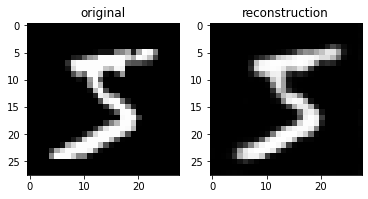

In [5]:
#porownanie orginalnego zdjecia i jego rekonstrukcji

original = mnist_data[0][0].unsqueeze(0)
emb = model.encoder(original)
recon_img = model.decoder(emb).detach().numpy()[0,0,:,:]

#orginalne zdjecie
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(original[0][0], cmap='gray')

#rekonstrukcja (nieco bardziej rozmyta)
plt.subplot(1,2,2)
plt.title("reconstruction")
plt.imshow(recon_img, cmap='gray')
plt.show()

In [6]:
emb.shape #wymiar embeddingu

torch.Size([1, 64, 1, 1])

In [7]:
emb2 = emb + 10 * torch.randn(1, 64, 1, 1) #zniekształćmy go lekko

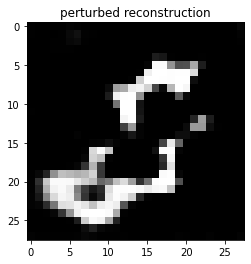

In [8]:
#rekonstrukcja poszla duzo gorzej

img = model.decoder(emb2)[0,0,:,:]
img = img.detach().numpy()
plt.title("perturbed reconstruction")
plt.imshow(img, cmap='gray')
plt.show()

<h4> Zadanie1: Zastanów się dlaczego funkcja kosztu MSE może nie być najlepszym pomysłem dla tego problemu? 

Skoro nie MSE to jaka funkcja? Nie wiem -> to może jej też się nauczę podczas procesu uczenia :)

<h4> $\textbf{GAN}$ składa się z dwóch modeli:
    
- $\textbf{Generatora}$ - sieć, której celem jest generowanie obrazu podobnego do tych z danych treningowych na podstawie embeddingu
- $\textbf{Dyskryminatora}$ - sieć, której celem jest rozpoznanie czy obraz pochodzi z danych treningowych czy może z generatora
    
W zasadzie mamy dwie sieci neuronowe o przeciwnych interesach: Generator ma oszukać Dyskryminator, Dyskryminator nie chce się oszukać przez Generator.

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(300, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out.view(x.size(0))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 300),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(300, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x).view(x.size(0), 1, 28, 28)
        return out

Zauważ, że jako funkcje aktywacji wybrano LeakyReLU. 

<h4> Zadanie2: Jaka jest różnica między funkcją ReLU i LeakyReLU. Jakie to ma konsekwencje?

Rozważmy następujące prawdopodobieństwa:

- prawdopodobieństwo, że dyskryminator poprawnie zidentyfikuje prawdziwe zdjęcie
- prawdopodobieństwo, że dyskryminator poprawnie zidentyfikuje zdjecie wygenerowane przez generator

Dyskryminator będzie chciał maksymalizować oba te prawdopodobieństwa. Z kolei Generator będzie chciał minimalizować drugie prawdopodobieństwo (na pierwsze nie ma wpływu, czemu?).

Jako, że wyraziliśmy cechy dyskryminatora i generatora w języku prawdopodobieństwa, wybierzemy jako funkcję kosztu BCE (binary cross entropy).

Dla dyskryminatora, niech 0 reprezentuje realne zdjęcie, 1 nieprawdziwe.

In [10]:
help(nn.BCEWithLogitsLoss)

Help on class BCEWithLogitsLoss in module torch.nn.modules.loss:

class BCEWithLogitsLoss(_Loss)
 |  BCEWithLogitsLoss(weight: Union[torch.Tensor, NoneType] = None, size_average=None, reduce=None, reduction: str = 'mean', pos_weight: Union[torch.Tensor, NoneType] = None) -> None
 |  
 |  This loss combines a `Sigmoid` layer and the `BCELoss` in one single
 |  class. This version is more numerically stable than using a plain `Sigmoid`
 |  followed by a `BCELoss` as, by combining the operations into one layer,
 |  we take advantage of the log-sum-exp trick for numerical stability.
 |  
 |  The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:
 |  
 |  .. math::
 |      \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
 |      l_n = - w_n \left[ y_n \cdot \log \sigma(x_n)
 |      + (1 - y_n) \cdot \log (1 - \sigma(x_n)) \right],
 |  
 |  where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
 |  (default ``'mean'``), then
 |  
 |  .. math:

In [11]:
def train(generator, discriminator, lr=0.001, num_epochs=5):
    criterion = nn.BCEWithLogitsLoss()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=100, shuffle=True)

    num_test_samples = 16
    test_noise = torch.randn(num_test_samples, 100)

    for epoch in range(num_epochs):
        #oba modele 
        generator.train()
        discriminator.train()


        for n, (images, _) in enumerate(train_loader):
            #Trening dyskryminatora

            noise = torch.randn(images.size(0), 100)
            fake_images = generator(noise)
            inputs = torch.cat([images, fake_images])
            labels = torch.cat([torch.zeros(images.size(0)), # prawdziwe
                                torch.ones(images.size(0))]) # falszywe

            discriminator.zero_grad()
            d_outputs = discriminator(inputs)
            d_loss = criterion(d_outputs, labels)
            d_loss.backward()
            d_optimizer.step()

            # Trening generatora
            noise = torch.randn(images.size(0), 100)
            fake_images = generator(noise)
            outputs = discriminator(fake_images)

            generator.zero_grad()
            g_loss = criterion(outputs, torch.zeros(images.size(0)))
            g_loss.backward()
            g_optimizer.step()

        scores = torch.sigmoid(d_outputs)
        real_score = scores[:images.size(0)].data.mean()
        fake_score = scores[images.size(0):].data.mean()


        print('Epoch [%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
              'D(x): %.2f, D(G(z)): %.2f' 
              % (epoch + 1, num_epochs, d_loss.item(), g_loss.item(), real_score, fake_score))
        
        #rysowanie
        generator.eval()
        discriminator.eval()
        test_images = generator(test_noise)
        plt.figure(figsize=(9, 3))
        for k in range(16):
            plt.subplot(2, 8, k+1)
            plt.imshow(test_images[k,:].data.numpy().reshape(28, 28), cmap='Greys')
        plt.show()

Epoch [1/15], d_loss: 0.0019, g_loss: 7.5539, D(x): 0.00, D(G(z)): 1.00


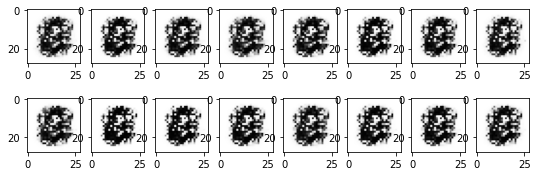

Epoch [2/15], d_loss: 0.0133, g_loss: 7.8799, D(x): 0.00, D(G(z)): 0.99


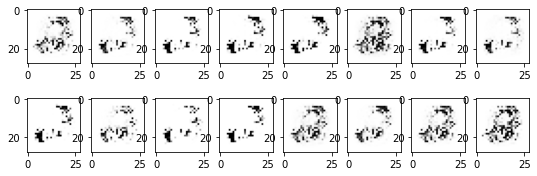

Epoch [3/15], d_loss: 0.0029, g_loss: 8.2848, D(x): 0.00, D(G(z)): 1.00


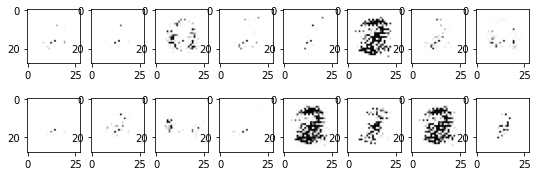

Epoch [4/15], d_loss: 0.0419, g_loss: 7.1281, D(x): 0.04, D(G(z)): 0.98


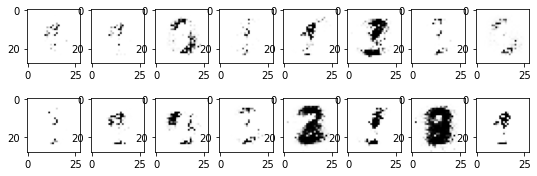

Epoch [5/15], d_loss: 0.0928, g_loss: 9.5592, D(x): 0.08, D(G(z)): 0.99


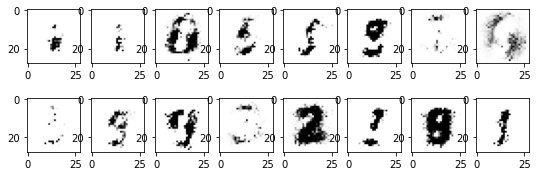

Epoch [6/15], d_loss: 0.0750, g_loss: 7.2417, D(x): 0.05, D(G(z)): 0.95


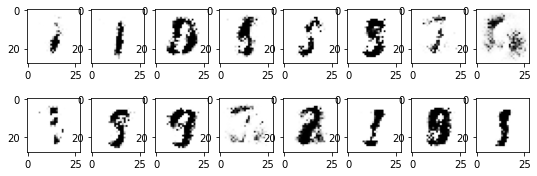

Epoch [7/15], d_loss: 0.0661, g_loss: 7.3011, D(x): 0.03, D(G(z)): 0.95


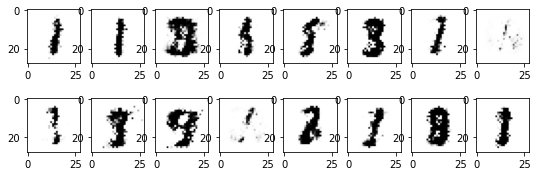

Epoch [8/15], d_loss: 0.0791, g_loss: 6.7109, D(x): 0.06, D(G(z)): 0.96


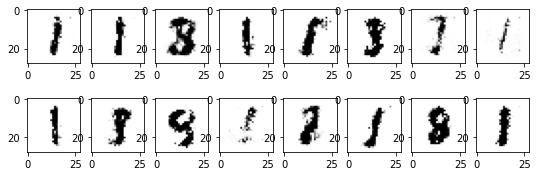

Epoch [9/15], d_loss: 0.1444, g_loss: 6.4747, D(x): 0.12, D(G(z)): 0.99


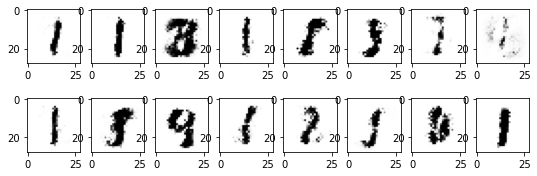

Epoch [10/15], d_loss: 0.2874, g_loss: 3.6978, D(x): 0.16, D(G(z)): 0.93


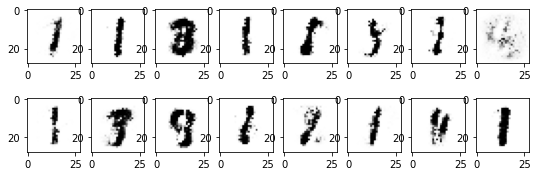

Epoch [11/15], d_loss: 0.1086, g_loss: 5.1162, D(x): 0.09, D(G(z)): 0.95


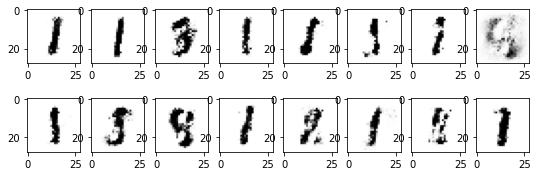

Epoch [12/15], d_loss: 0.1545, g_loss: 4.2386, D(x): 0.09, D(G(z)): 0.89


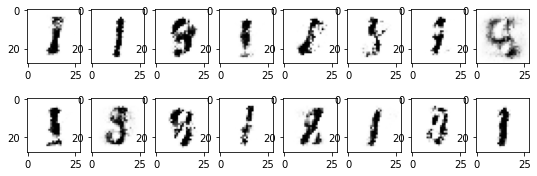

Epoch [13/15], d_loss: 0.1354, g_loss: 3.4818, D(x): 0.09, D(G(z)): 0.90


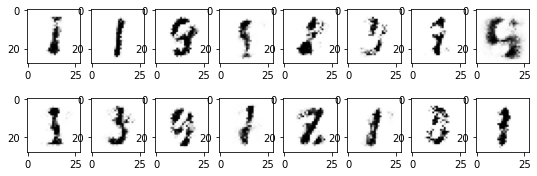

Epoch [14/15], d_loss: 0.1890, g_loss: 3.5560, D(x): 0.12, D(G(z)): 0.88


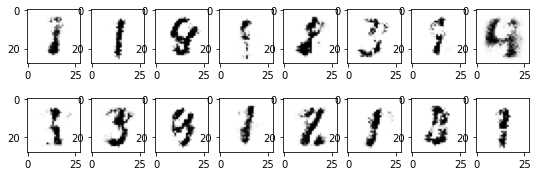

Epoch [15/15], d_loss: 0.1635, g_loss: 4.1627, D(x): 0.12, D(G(z)): 0.90


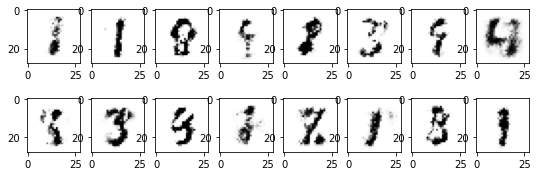

In [12]:
discriminator = Discriminator()
generator = Generator()
train(generator, discriminator, lr=0.001, num_epochs=15)

GANs są trudne do trenowania... 

<h4> Zadanie3: Jak zachowuje się funkcja kosztu w kolejnych epokach? Z czego to może wynikać? Czy to ułatwia czy utrudnia dostosowyanie hiperparametrów?

<h4> Zadanie4: Generator może realizować swój cel ucząć się bardzo dobrze generować tylko pewien podzbiór danych (np jedną cyfrę). Zjawisko to nosi nazwę $\textbf{mode collapse}$. Poszukaj jak można rozwiązać ten problem.

Warto poczytać: https://developers.google.com/machine-learning/gan/problems

Używają GAN np tutaj: https://thispersondoesnotexist.com/, https://www.whichfaceisreal.com/

Warto przeczytać: https://junyanz.github.io/CycleGAN/

<h3> Ataki adwersalne

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

mnist_images = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5, padding=2)
        self.fc1 = nn.Linear(10 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [36]:
def train(model, data, batch_size=64, lr=0.001, num_iters=1000, print_every=100): 
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    n = 0

    while True:
        for imgs, labels in iter(train_loader):
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            n += 1
        
            if n % print_every == 0:
                print("Iter %d. Avg.Loss: %f" % (n, total_loss/print_every))
                total_loss = 0
            if n > num_iters:
                return

In [37]:
fc_model = FCNet()
train(fc_model, mnist_images, num_iters=1000)

Iter 100. Avg.Loss: 1.411251
Iter 200. Avg.Loss: 0.561205
Iter 300. Avg.Loss: 0.444292
Iter 400. Avg.Loss: 0.350206
Iter 500. Avg.Loss: 0.354865
Iter 600. Avg.Loss: 0.326648
Iter 700. Avg.Loss: 0.319265
Iter 800. Avg.Loss: 0.314465
Iter 900. Avg.Loss: 0.258636
Iter 1000. Avg.Loss: 0.215988


In [38]:
cnn_model = ConvNet()
train(cnn_model, mnist_images, num_iters=1000)

Iter 100. Avg.Loss: 1.389529
Iter 200. Avg.Loss: 0.486592
Iter 300. Avg.Loss: 0.378801
Iter 400. Avg.Loss: 0.267068
Iter 500. Avg.Loss: 0.259619
Iter 600. Avg.Loss: 0.211093
Iter 700. Avg.Loss: 0.203777
Iter 800. Avg.Loss: 0.194760
Iter 900. Avg.Loss: 0.151438
Iter 1000. Avg.Loss: 0.119982


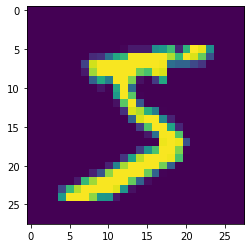

In [17]:
image = mnist_images[0][0]
target_label = 3
model = fc_model

plt.imshow(image[0])
plt.show()

In [18]:
#generujemy losowy szum

noise = torch.randn(1, 28, 28) * 0.01
noise.requires_grad = True

In [19]:
#lekko "optymalizujemy" zeby byl dobrą zmyłką

optimizer = optim.Adam([noise], lr=0.01, weight_decay=1)
criterion = nn.CrossEntropyLoss()

for i in range(1000):
    adv_image = torch.clamp(image + noise, 0, 1)
    out = model(adv_image.unsqueeze(0))
    loss = criterion(out, torch.Tensor([target_label]).long())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

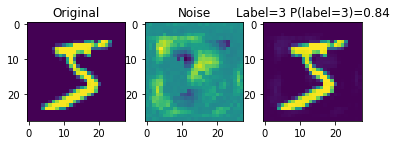

In [20]:
#efekt 

adv_image = torch.clamp(image + noise, 0, 1)
adv_label = torch.argmax(model(adv_image), dim=1).item()
adv_percent = torch.softmax(model(adv_image), dim=1)[0,target_label].item()

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image[0])

plt.subplot(1, 3, 2)
plt.title("Noise")
plt.imshow(noise[0].detach().numpy())

plt.subplot(1, 3, 3)
plt.title("Label=%d P(label=%d)=%.2f" % (adv_label, target_label, adv_percent))
plt.imshow(adv_image.detach().numpy()[0])

<h3> Problem regularyzacji

W sieciach neuronowych często może dochodzić do zjawiska przetrenowania. Związane jest to m.in. z dużą swobodą w wyborze liczby parametrów. Jak temu przeciwdziałać?

- użyć więcej danych do trenowania
- zbudować mniejszą sieć (=mniej parametrów)
- dzielenie wag (weight sharing), jak np w konwolucyjnych sieciach neuronowych zastosowanie kernela dla wszystkich pozycji w obrazie
- odpowiednie wczesne zakończenie procesu uczenia (kontrolowane np poprzez zbiór walidacyjny)

Co można zrobić więcej?
- zwiększenie danych (często na podstawie istniejących przykładów)
- normalizacja danych (np BatchNormalizacja)
- uśrednianie modeli
- dropout

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [22]:
torch.manual_seed(1) #dla powtarzalnosci wynikow

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:100]     #zalozmy ze mamy tylko pierwsze 100 danych
mnist_val   = mnist_data[100:5100] #reszta do walidacji

In [23]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [24]:
def train(model, train, valid, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    while True:
        if n >= num_iters:
            break
        for imgs, labels in iter(train_loader):
            model.train()
            out = model(imgs)             
            loss = criterion(out, labels) # liczymy funkcje kosztu
            loss.backward()               
            optimizer.step()              # update parametrow
            optimizer.zero_grad()         #zerujemy gradient


            if n % 10 == 9:
                iters.append(n)
                losses.append(float(loss)/batch_size)             # srednia funkcja kosztu
                train_acc.append(get_accuracy(model, train)) # dokladnosc na treningowym
                val_acc.append(get_accuracy(model, valid))  # dokladnosc na walidacyjnym
            n += 1

    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval()
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs) 
        pred = output.max(1, keepdim=True)[1] # index gdzie maksymalny logarytm prawdopodobienstwa
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

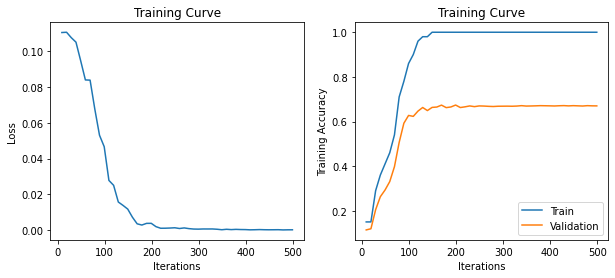

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.67


In [25]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_iters=500)

Widać przetrenowanie modelu

<h4> Zwiększanie danych

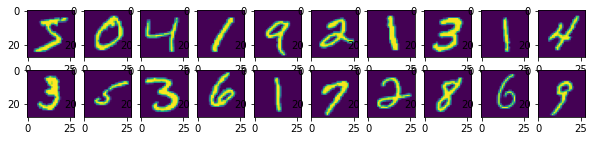

In [26]:
def show20(data):
    plt.figure(figsize=(10,2))
    for n, (img, label) in enumerate(data):
        if n >= 20:
            break
        plt.subplot(2, 10, n+1)
        plt.imshow(img)

mnist_imgs = datasets.MNIST('data', train=True, download=True)
show20(mnist_imgs)

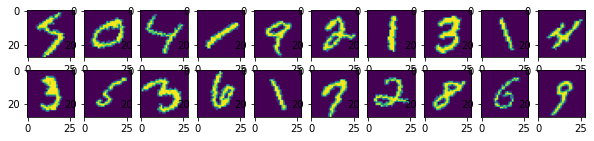

In [27]:
mnist_new = datasets.MNIST('data', train=True, download=True, transform=transforms.RandomRotation(25))
show20(mnist_new)

In [28]:
augmented_train_data = []

my_transform = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ToTensor(),
])

for i in range(100):
    mnist_new = datasets.MNIST('data', train=True, download=True, transform=my_transform)
    for j, item in enumerate(mnist_new):
        if j >= 100:
            break
        augmented_train_data.append(item)

len(augmented_train_data)

10000

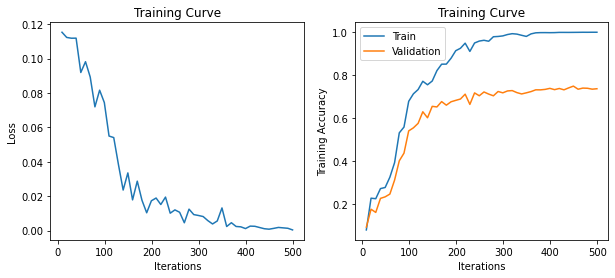

Final Training Accuracy: 0.9991
Final Validation Accuracy: 0.7364


In [29]:
model = MNISTClassifier()
train(model, augmented_train_data, mnist_val, num_iters=500)

<h3> Regularyzacja $L_1$ i $L_2$ czyli weight decay - czyli powstrzymywanie przed estymacją dużych wag. W pytroch większość optymalizatorów stosuje $L_2$

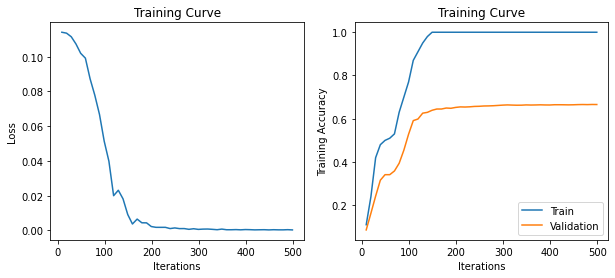

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6658


In [30]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_iters=500, weight_decay=0.001)

<h3> Dropout

- losowo wyłączamy pewną grupę neuronów podczas uczenia (w różnych iteracjach inne) --> powoduje uniezależnianie wag od innych. 
- podczas testowania korzystamy z pełni połączonej sieci (która może być traktowana jako uśrednienie tych z dropoutem)

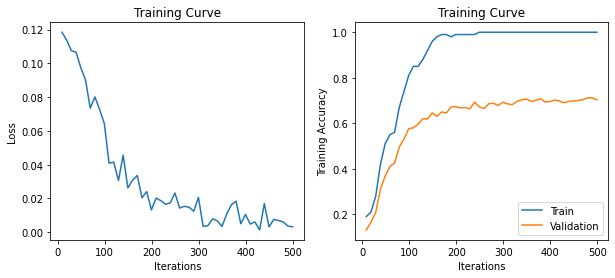

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7032


In [31]:
class MNISTClassifierWithDropout(nn.Module):
    def __init__(self):
        super(MNISTClassifierWithDropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(0.2) 
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(self.dropout1(flattened)))
        activation2 = F.relu(self.layer2(self.dropout2(activation1)))
        output = self.layer3(self.dropout3(activation2))
        return output

model = MNISTClassifierWithDropout()
train(model, mnist_train, mnist_val, num_iters=500)

<h4> Zadanie5: CIFAR10 to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 x 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

https://www.cs.toronto.edu/~kriz/cifar.html

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


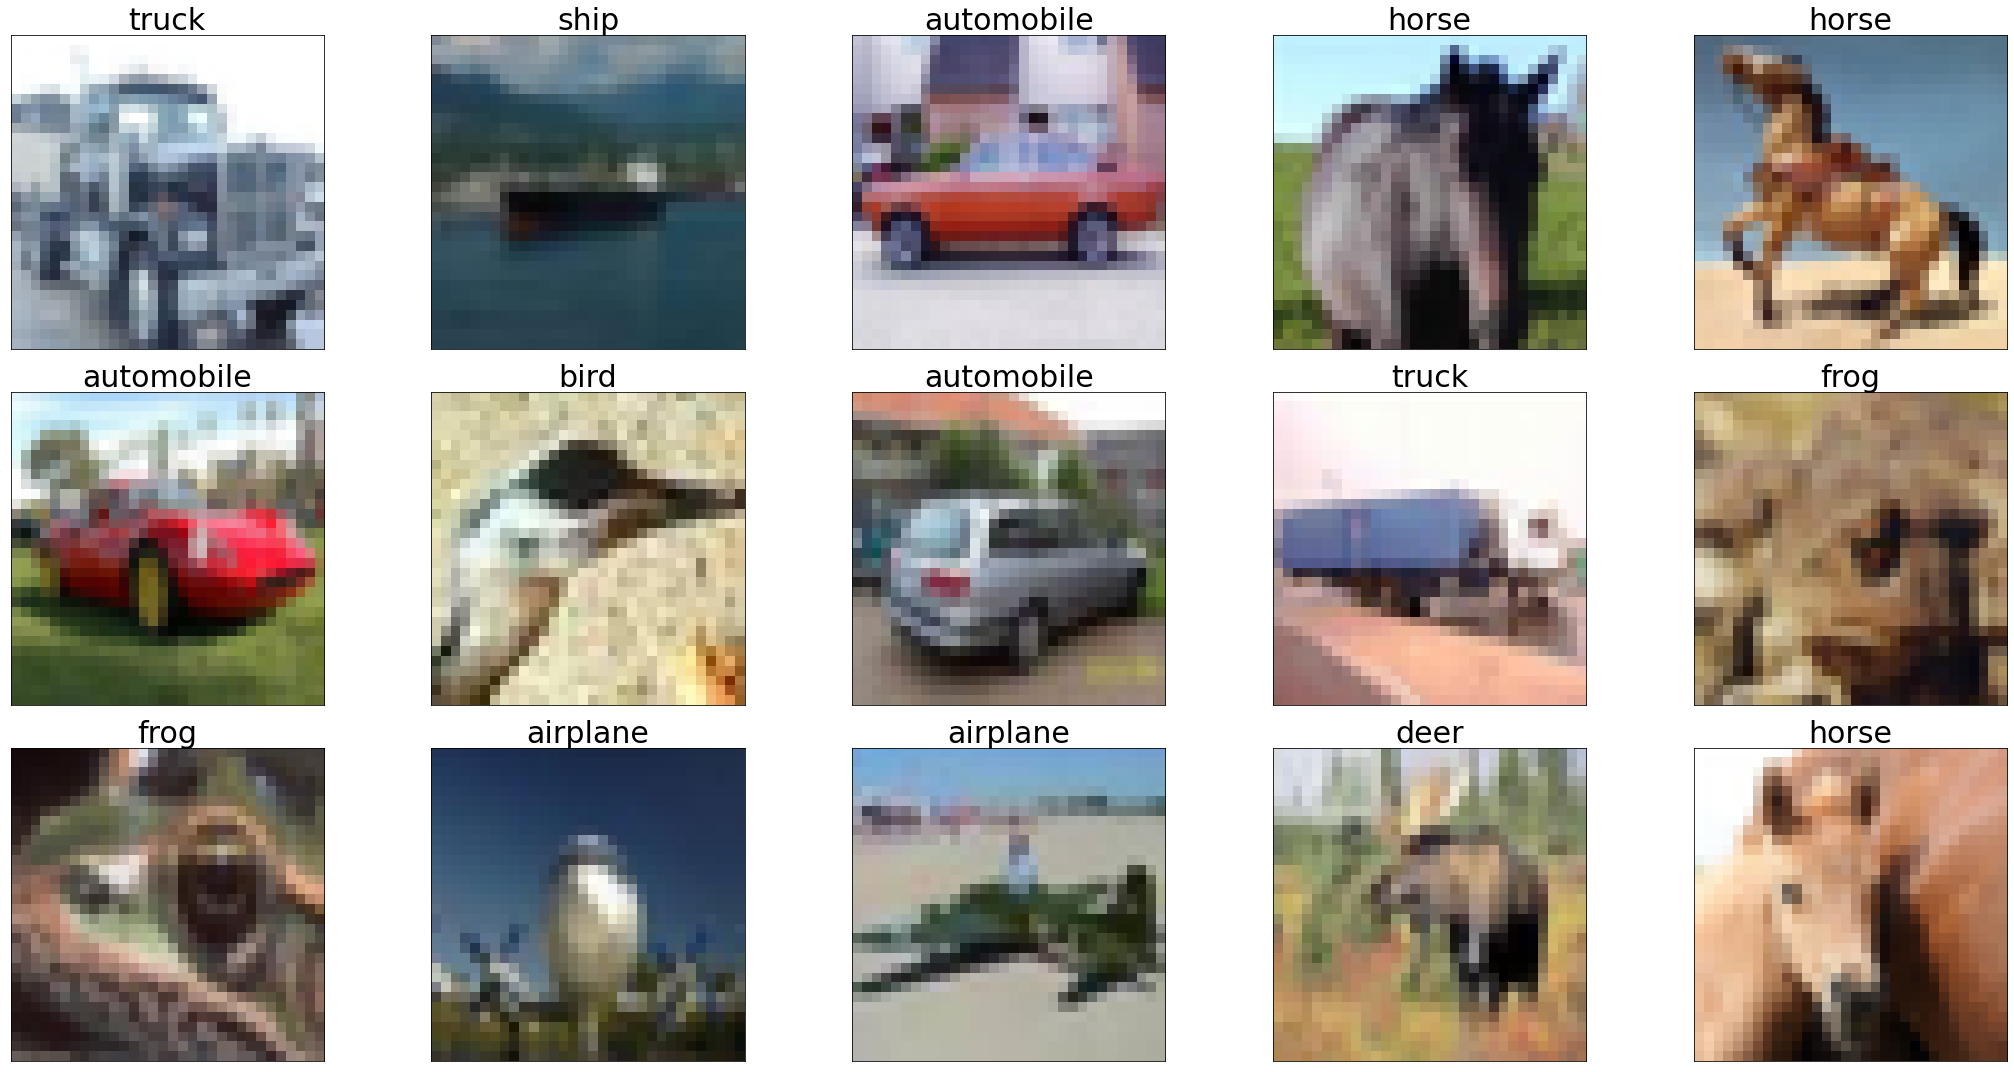

In [32]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader


dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

for x, y in loader:
    break

#wizaulizacja
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")


<h4> Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować loss w trakcie trenowania, testowania oraz accuracy na zbiorze testowym (opcjonalnie również na treningowym). Na koniec accuracy powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

- Zwiększenie treningowego batch size może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, batch_size ma wpływ na proces uczenia.
    
- Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)